# Finite-strain $\boldsymbol{F}^\text{e}\boldsymbol{F}^\text{p}$ plasticity

$\newcommand{\bF}{\boldsymbol{F}}\newcommand{\bFe}{\boldsymbol{F}^\text{e}}\newcommand{\bFp}{\boldsymbol{F}^\text{p}}$

In this example, we show how to use a JAX implementation of finite-strain plasticity using the $\bFe\bFp$ formalism. The material behavior is described in the [`jaxmat` documentation](https://bleyerj.github.io/jaxmat/demos/quickstart/performance.html#material-model).

The setup of the FEniCSx variational problem is quite similar to the MFront [](./../../mfront/finite_strain_elastoplasticity/finite_strain_elastoplasticity.ipynb) demo.

This demo runs in parallel. By default, JAX will allocate the full GPU memory for each process, which will fail when running with more than 1 MPI processor. Thus we first deallocate automatic GPU memory preallocation. The relevant packages are then imported.

In [8]:
import os
from mpi4py import MPI

# Avoid JAX preallocating all GPU memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# --- Import JAX AFTER setting env vars ---
import jax


jax.config.update("jax_platform_name", "gpu")
import numpy as np
from pathlib import Path
import gmsh
import ufl
from dolfinx import fem, io
from dolfinx.common import timing
from dolfinx_materials.quadrature_map import QuadratureMap
from dolfinx_materials.solvers import NonlinearMaterialProblem
from dolfinx_materials.utils import nonsymmetric_tensor_to_vector

import jaxmat.materials as jm
from dolfinx_materials.jaxmat import JAXMaterial

comm = MPI.COMM_WORLD
rank = comm.rank

dim = 3
L = 10.0  # rod half-length
W = 2.0  # rod diameter
R = 20.0  # notch radius
d = 0.2  # cross-section reduction
coarse_size = 0.5
fine_size = 0.2

The mesh consists of a quarter of cylindrical rod with a slightly reduced cross-section at its center to induce necking. The geometry is defined with `gmsh` API and the Open-Cascade kernel.

In [9]:
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 0)  # to disable meshing info

if rank == 0:
    rectangle = gmsh.model.occ.addRectangle(0, 0, 0, L, W)
    tool = gmsh.model.occ.addDisk(0, W - d + R, 0, R, R)
    vol_dimTag = (dim - 1, rectangle)
    out = gmsh.model.occ.cut([vol_dimTag], [(dim - 1, tool)])

    out = gmsh.model.occ.revolve(out[0], 0, 0, 0, 1, 0, 0, np.pi / 2)
    gmsh.model.occ.synchronize()

    gmsh.model.addPhysicalGroup(dim, [1], 1, name="Matrix")
    gmsh.model.addPhysicalGroup(dim - 1, [2], 1, name="bottom")
    gmsh.model.addPhysicalGroup(dim - 1, [6], 2, name="side_Y")
    gmsh.model.addPhysicalGroup(dim - 1, [1], 3, name="side_Z")
    gmsh.model.addPhysicalGroup(dim - 1, [5], 4, name="top")

    field_tag = gmsh.model.mesh.field.add("Box")
    gmsh.model.mesh.field.setNumber(field_tag, "VIn", fine_size)
    gmsh.model.mesh.field.setNumber(field_tag, "VOut", coarse_size)
    gmsh.model.mesh.field.setNumber(field_tag, "XMin", -W)
    gmsh.model.mesh.field.setNumber(field_tag, "XMax", W)
    gmsh.model.mesh.field.setNumber(field_tag, "YMin", 0)
    gmsh.model.mesh.field.setNumber(field_tag, "YMax", W)
    gmsh.model.mesh.field.setNumber(field_tag, "ZMin", 0)
    gmsh.model.mesh.field.setNumber(field_tag, "ZMax", W)
    gmsh.model.mesh.field.setNumber(field_tag, "Thickness", W)

    gmsh.model.mesh.field.setAsBackgroundMesh(field_tag)

    gmsh.model.mesh.generate(dim)

mesh_data = io.gmsh.model_to_mesh(gmsh.model, comm, 0)
cell_markers = mesh_data.cell_tags
facets = mesh_data.facet_tags
domain = mesh_data.mesh

gmsh.finalize()

Horizontal traction with free transverse displacement is imposed at the rod extremities, symmetry boundary conditions are enforced on other plane surfaces.

In [10]:
fdim = dim - 1
domain.topology.create_connectivity(fdim, dim)

order = 2
V = fem.functionspace(domain, ("P", order, (dim,)))
deg_quad = 2 * (order - 1)
V_x, _ = V.sub(0).collapse()
V_y, _ = V.sub(1).collapse()
V_z, _ = V.sub(2).collapse()


bottom_x_dofs = fem.locate_dofs_topological((V.sub(0), V_x), fdim, facets.find(1))
top_x_dofs = fem.locate_dofs_topological((V.sub(0), V_x), fdim, facets.find(4))
side_y_dofs = fem.locate_dofs_topological((V.sub(1), V_y), fdim, facets.find(2))
side_z_dofs = fem.locate_dofs_topological((V.sub(2), V_z), fdim, facets.find(3))

u0_x = fem.Function(V_x)
u0_y = fem.Function(V_y)
u0_z = fem.Function(V_z)
uD_x = fem.Function(V_x)
bcs = [
    fem.dirichletbc(u0_y, bottom_x_dofs, V.sub(0)),
    fem.dirichletbc(u0_y, side_y_dofs, V.sub(1)),
    fem.dirichletbc(u0_z, side_z_dofs, V.sub(2)),
    fem.dirichletbc(uD_x, top_x_dofs, V.sub(0)),
]

As in the MFront hyperelastic demo, the nonlinear residual based on PK1 stress is used. The `jaxmat` `FeFpJ2Plasticity` behavior is defined based on an elastic material and a Voce isotropic hardening.

In [11]:
Id = ufl.Identity(dim)


def F(u):
    return nonsymmetric_tensor_to_vector(Id + ufl.grad(u))


def dF(u, v):
    return ufl.derivative(F(u), u, v)


du = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
u = fem.Function(V, name="Displacement")

E = 70e3
nu = 0.3
sig0 = 500.0

b = 1000
sigu = 750.0

elasticity = jm.LinearElasticIsotropic(E=E, nu=nu)

hardening = jm.VoceHardening(sig0=sig0, sigu=sigu, b=b)

behavior = jm.FeFpJ2Plasticity(elasticity=elasticity, yield_stress=hardening)

material = JAXMaterial(behavior)

qmap = QuadratureMap(domain, deg_quad, material)
qmap.register_gradient("F", F(u))

P = qmap.fluxes["PK1"]
Res = ufl.dot(P, dF(u, v)) * qmap.dx
Jac = qmap.derivative(Res, u, du)

This material model relies on an elastic left Cauchy-Green internal state variable $\overline{\boldsymbol{b}}^\text{e}$ describing the intermediate elastic configuration. The latter is automatically initialized with the identity tensor to specify a natural unstressed elastic configuration. We use a first call to the material update function to enforce compilation of the JAX behavior.

In [12]:
qmap.update()

## Resolution

We now define a custom nonlinear problem and pass the corresponding SNES options. We use a GMRES Krylov solver and a Geometric Algebraic MultiGrid preconditioner.

In [13]:
petsc_options = {
    "snes_type": "newtonls",
    "snes_linesearch_type": "none",
    "snes_atol": 1e-8,
    "snes_rtol": 1e-8,
    "ksp_type": "gmres",
    "ksp_rtol": 1e-8,
    "pc_type": "gamg",
}
problem = NonlinearMaterialProblem(
    qmap,
    Res,
    u,
    bcs=bcs,
    J=Jac,
    petsc_options_prefix="elastoplasticity",
    petsc_options=petsc_options,
)
# -

We loop over an imposed increasing horizontal strain and solve the nonlinear problem. We output the displacement and equivalent plastic strain variables. Finally, we measure the time spent by each rank on the constitutive update and the SNES solver and print the average values on rank 0.

In [14]:
results_folder = Path("results")
results_folder.mkdir(exist_ok=True, parents=True)
filename = results_folder / "finite_strain_plasticity"
V0 = fem.functionspace(domain, ("DG", 0))
p = fem.Function(V0, name="p")
vtx = io.VTXWriter(domain.comm, filename.with_suffix(".bp"), [u, p])

N = 20
Exx = np.linspace(0, 30e-3, N + 1)
average_stats = np.zeros((N, 3))
for i, exx in enumerate(Exx[1:]):
    uD_x.x.petsc_vec.set(exx * L)

    problem.solve()

    converged = problem.solver.getConvergedReason()
    num_iter = problem.solver.getIterationNumber()
    assert converged > 0, f"Solver did not converge, got {converged}."

    constitutive_update_time = timing("SNES: constitutive update")[1].total_seconds()
    snes_time = timing("SNES: solve")[1].total_seconds()

    all_stats = None
    if rank == 0:
        all_stats = np.zeros((comm.size, 3))
    comm.Gather(
        np.array([constitutive_update_time, snes_time, num_iter]), all_stats, root=0
    )

    if rank == 0:
        average_stats[i, :] = np.mean(all_stats, axis=0)
        print(
            f"Increment {i} converged after {num_iter} iterations with converged reason {converged}.\n"
        )

        print(f"Dolfinx SNES time = {average_stats[i, 1]:.3f}")
        print(f"Pure solver time = {average_stats[i, 1]-average_stats[i, 0]:.3f}")
        print(f"Constitutive update time = {average_stats[i, 0]:.3f}\n")

    qmap.project_on("p", ("DG", 0), fun=p)

    vtx.write(i + 1)
    np.savetxt(
        filename.with_suffix(".csv"),
        average_stats,
        delimiter=",",
        header="Constitutive update time, SNES solve, num iterations",
    )

vtx.close()

Increment 0 converged after 2 iterations with converged reason 3.

Dolfinx SNES time = 3.118
Pure solver time = 2.033
Constitutive update time = 1.085

Increment 1 converged after 2 iterations with converged reason 3.

Dolfinx SNES time = 4.628
Pure solver time = 2.971
Constitutive update time = 1.656

Increment 2 converged after 2 iterations with converged reason 3.

Dolfinx SNES time = 6.039
Pure solver time = 3.897
Constitutive update time = 2.143

Increment 3 converged after 3 iterations with converged reason 3.

Dolfinx SNES time = 8.222
Pure solver time = 5.325
Constitutive update time = 2.897

Increment 4 converged after 4 iterations with converged reason 2.

Dolfinx SNES time = 11.236
Pure solver time = 7.316
Constitutive update time = 3.921

Increment 5 converged after 3 iterations with converged reason 3.

Dolfinx SNES time = 13.574
Pure solver time = 8.857
Constitutive update time = 4.716

Increment 6 converged after 5 iterations with converged reason 2.

Dolfinx SNES time =

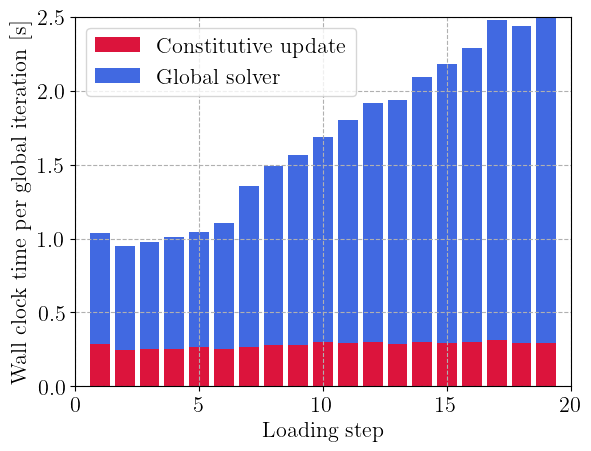

In [15]:
import matplotlib.pyplot as plt

num_iter = average_stats[:, 2]
constitutive_time = np.diff(average_stats[:, 0], prepend=average_stats[0, 0]) / num_iter
solver_time = np.diff(average_stats[:, 1], prepend=average_stats[0, 1]) / num_iter
plt.bar(np.arange(N), constitutive_time, color="crimson", label="Constitutive update")
plt.bar(
    np.arange(N),
    solver_time,
    bottom=constitutive_time,
    color="royalblue",
    label="Global solver",
)
plt.xlabel("Loading step")
plt.ylabel("Wall clock time per global iteration [s]")
plt.xlim(0, N)
plt.legend()
plt.show()